In [1]:
import urllib.request
import os.path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


#  utilities 

def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))

#reshape Data
# sample n frame from videos
def my_reshape(data_in ,number_of_frame = 2):
    N, M, H, W = data_in.shape
    n = M-number_of_frame+1
    data_out = np.zeros((n * N, number_of_frame, 64, 64),'uint8')
    for j in range(N):
        for i in range(n):
            data_out[j*n+i] = data_in[j, i:i+number_of_frame]
    
    return data_out

#show filter 
def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    pylab.imshow(im, cmap=cm.gray, interpolation='nearest', **kwargs)
    pylab.show()
    
# Manage Data
class Dataset:
    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass


    @property
    def data(self):
        return self._data

    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]
        
numpy_rng = np.random.RandomState(1)
SMALL = 0.000001

In [2]:

# LOAD DATA
file_name = 'mnist_test_seq.npy'
if not os.path.isfile(file_name):
    print("could not find moving mnist: download it..")
    url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'
    urllib.request.urlretrieve(url, file_name)
    print("download complete")
else :
    print ("Data Exist")
    
data = np.load(file_name)
print (data.shape)

num_data = data.shape[1]

idx =  np.arange(0, num_data)
np.random.shuffle(idx)

num_train = int( 0.7 * num_data)
print (num_train)
train_idx = idx[0:num_train]
test_idx = idx [num_train:num_data]

data_train = data[:,train_idx,:,:]
data_test = data[:,test_idx,:,:]


print ("data_train " ,data_train.shape ,"data_test " ,data_test.shape   ) 





Data Exist
(20, 10000, 64, 64)
7000
data_train  (20, 7000, 64, 64) data_test  (20, 3000, 64, 64)


In [3]:
if not os.path.isfile('mean_all.npy'):
    # Get mean and variance of all frames 
    print ('calculate total mean and var')
    data_1 = (my_reshape(data, 1)).astype('float32')
    v,n,h,w = data_1.shape
    data_1 = data_1.reshape((v,h * w))

    mean_all = data_1.mean(0)[None,:]
    data_1 -= mean_all

    var_all = data_1.std(0)  + data_1.std() * 0.1

    np.save("mean_all", mean_all)
    np.save("var_all", var_all)
else :
    print ('load mean and var')
    mean_all = np.load('mean_all.npy')
    var_all = np.load('var_all.npy')

load mean and var


In [4]:
#data for first layer pretraining 
data_1 = my_reshape(data_train, 2)

v,n,h,w = data_1.shape
data_1 = data_1.reshape((v,n,h * w))
print ("data_1 " ,data_1.shape)

x_dim = data_1.shape[2] 

ntrain = data_1.shape[0]
dataset = Dataset(data_1)
data_1 =0


data_1  (139980, 2, 4096)


In [5]:
# Model for first layer pretrainig
numfac1  = 512
nummap1  = 256

input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])

mean = tf.constant(mean_all)
var = tf.constant(var_all)

input_x1_scaled = (input_x1 - mean ) / var
input_x2_scaled = (input_x2 - mean ) / var
if not os.path.isfile('U1.npy'):
    print ("initialize weights randomly")
    U1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac1)) * 0.01)
    V1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac1)) * 0.01)
    W1 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac1, nummap1)).astype('float32'))

    bias_W1 = tf.Variable(np.zeros(nummap1, dtype='float32'))
else :
    print ("Load weights from file")
    U1 = tf.Variable(np.load("U1.npy"))
    V1 = tf.Variable(np.load("V1.npy"))
    W1 = tf.Variable(np.load("W1.npy"))

    bias_W1 = tf.Variable(np.load("bias_W1.npy"))
    

# m=sig(W(U*X1 . V*X2 ))
M1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1_scaled,U1) ,tf.matmul(input_x2_scaled,V1) ), W1)+ bias_W1)

output_x1 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) ,tf.matmul(input_x2_scaled,V1) ),tf.transpose(U1))
output_x2 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) ,tf.matmul(input_x1_scaled,U1) ), tf.transpose(V1))

cost_1 = tf.nn.l2_loss(output_x1-input_x1_scaled) + tf.nn.l2_loss(output_x2-input_x2_scaled)
#cost_1 = tf.nn.l2_loss(output_x2-input_x2)
optimizer_1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_1)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)

initialize weights randomly


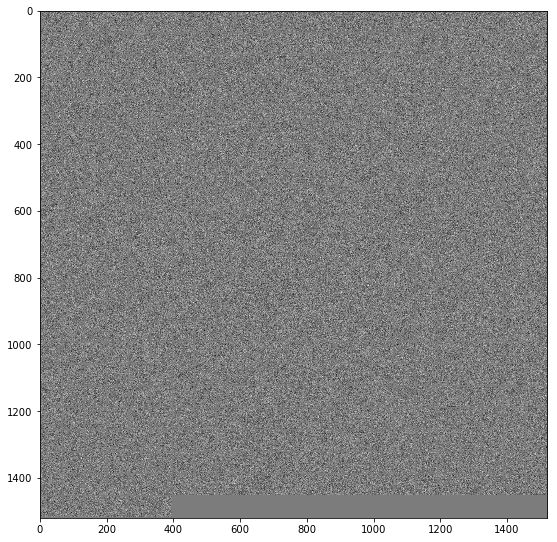

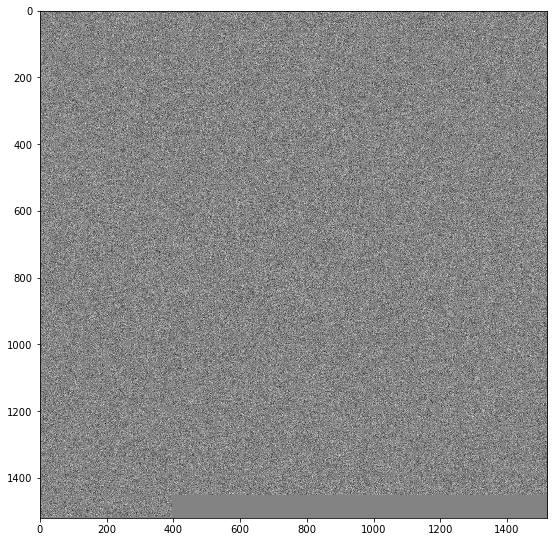

I: 000/41700  E: 000 i:000/139 cost: 2488.366000000
I: 001/41700  E: 000 i:001/139 cost: 2539.134000000
I: 002/41700  E: 000 i:002/139 cost: 2544.069000000
I: 003/41700  E: 000 i:003/139 cost: 2470.933500000
I: 004/41700  E: 000 i:004/139 cost: 2461.898000000
I: 005/41700  E: 000 i:005/139 cost: 2486.496250000
I: 006/41700  E: 000 i:006/139 cost: 2526.162000000
I: 007/41700  E: 000 i:007/139 cost: 2433.917000000
I: 008/41700  E: 000 i:008/139 cost: 2535.806250000
I: 009/41700  E: 000 i:009/139 cost: 2505.448000000
I: 010/41700  E: 000 i:010/139 cost: 2495.121500000
I: 011/41700  E: 000 i:011/139 cost: 2444.683000000
I: 012/41700  E: 000 i:012/139 cost: 2424.955250000
I: 013/41700  E: 000 i:013/139 cost: 2507.814500000


KeyboardInterrupt: 

In [6]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 300 


with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    
    fig = pylab.figure(figsize=(20, 20)) 
    pylab.subplot(1, 2, 1)
    dispims(U1.eval(sess), 64, 64, 2)
    fig = pylab.figure(figsize=(20, 20)) 
    pylab.subplot(1, 2, 2)
    dispims(V1.eval(sess), 64, 64, 2)
    
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            
#             batch_x1s -= mean_all
#             batch_x2s -= mean_all
            
#             batch_x1s /= var_all
#             batch_x2s /= var_all
     
            sess.run(optimizer_1, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s})
            sess.run(normalize_U1)
            sess.run(normalize_V1)

            cost_ = sess.run(cost_1, feed_dict={input_x1: batch_x1s.astype('float32'), input_x2: batch_x2s.astype('float32')}) 
            total_cost += cost_
            print ("I: %03d/%03d  E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        fig = pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 1)
        dispims(U1.eval(sess), 64, 64, 2)
        fig = pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 2)
        dispims(V1.eval(sess), 64, 64, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) ) 
        np.save("U1", np.array(U1.eval(sess)))
        np.save("V1", np.array(V1.eval(sess)))
        np.save("W1", np.array(W1.eval(sess)))
        np.save("bias_W1", np.array(bias_W1.eval(sess)))

dataset=0

In [ ]:
# Model for first order relational Auto Encoder 
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])

if not os.path.isfile('UR1.npy'):
    U1 = tf.Variable(np.load("U1.npy"))
    V1 = tf.Variable(np.load("V1.npy"))
    W1 = tf.Variable(np.load("W1.npy"))
    bias_W1 = tf.Variable(np.load("bias_W1.npy"))
else:#Continue learning 
    U1 = tf.Variable(np.load("UR1.npy"))
    V1 = tf.Variable(np.load("VR1.npy"))
    W1 = tf.Variable(np.load("WR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WR1.npy"))
    

# m=sig(W(U*X1 . V*X2 ))
M1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)

output_x3 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) ,tf.matmul(input_x2,V1) ),tf.transpose(U1))
cost_R1 = tf.nn.l2_loss(output_x3-input_x3) 

optimizer_R1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_R1)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)

In [ ]:
#data for Second layer pretraining 
data_2 = my_reshape(data_train, 3) # get 3 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)
data_2=0

In [ ]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 300 

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            batch_x3s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
            batch_x3s /= var_all
     
            sess.run(optimizer_R1, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s})
            sess.run(normalize_U1)
            sess.run(normalize_V1)

            cost_ = sess.run(cost_R1, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        fig = pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 1)
        dispims(U1.eval(sess), 64, 64, 2)
        fig = pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 2)
        dispims(V1.eval(sess), 64, 64, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) ) 
        np.save("UR1", np.array(U1.eval(sess)))
        np.save("VR1", np.array(V1.eval(sess)))
        np.save("WR1", np.array(W1.eval(sess)))
        np.save("bias_WR1", np.array(bias_W1.eval(sess)))
        
dataset2=0

In [ ]:
# Model for Second layer pretrainig
numfac2  = 512
nummap2  = 256

#first layer fixed 
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])

# weights
U1 = tf.constant(np.load("UR1.npy"))
V1 = tf.constant(np.load("VR1.npy"))
W1 = tf.constant(np.load("WR1.npy"))

bias_W1 = tf.constant(np.load("bias_W1.npy"))


M1_1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)
M1_2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x2,U1) ,tf.matmul(input_x3,V1) ), W1)+ bias_W1)

#second layer 
if not os.path.isfile('U2.npy'): 
    U2 = tf.Variable(tf.random_normal(shape=(nummap1, numfac2)) * 0.01)
    V2 = tf.Variable(tf.random_normal(shape=(nummap1, numfac2)) * 0.01)
    W2 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac2, nummap2)).astype('float32'))

    bias_W2 = tf.Variable(np.zeros(nummap2, dtype='float32'))
else :#load saved weights and Continue 
    print ("Load weights for second layer from file")
    U2 = tf.Variable(np.load("U2.npy"))
    V2 = tf.Variable(np.load("V2.npy"))
    W2 = tf.Variable(np.load("W2.npy"))

    bias_W2 = tf.Variable(np.load("bias_W2.npy"))
    
    
M2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(M1_1,U2) ,tf.matmul(M1_2,V2) ), W2)+ bias_W2)


output_M1_1 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_2,V2) ),tf.transpose(U2))
output_M1_2 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_1,U2) ),tf.transpose(V2))

#cost_2 = tf.nn.l2_loss(output_M1_1-M1_1) + tf.nn.l2_loss(output_M1_2-M1_2)
cost_2 =  tf.nn.l2_loss(output_M1_2-M1_2)

optimizer_2 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_2)

U2_normalized = tf.nn.l2_normalize(U2, [0,1], epsilon=1e-12, name=None)
V2_normalized = tf.nn.l2_normalize(V2, [0,1], epsilon=1e-12, name=None)

normalize_U2 = U2.assign(U2_normalized)
normalize_V2 = V2.assign(V2_normalized)

In [ ]:
#data for Second layer pretraining 
data_2 = my_reshape(data_train, 3) # get 3 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)
data_2=0

In [ ]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 300 

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            batch_x3s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
            batch_x3s /= var_all
     
            sess.run(optimizer_2, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s})
            sess.run(normalize_U2)
            sess.run(normalize_V2)

            cost_ = sess.run(cost_2, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 1)
        dispims(U2.eval(sess), 16, 16, 2)
        pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 2)
        dispims(V2.eval(sess), 16, 16, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) ) 
        np.save("U2", np.array(U2.eval(sess)))
        np.save("V2", np.array(V2.eval(sess)))
        np.save("W2", np.array(W2.eval(sess)))
        np.save("bias_W2", np.array(bias_W2.eval(sess)))
        
dataset2=0

In [ ]:
# Model of  second order relational auto encoder
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])
input_x4 = tf.placeholder(tf.float32, [None, x_dim])

# weights for first layer URR1
if not os.path.isfile('URR1.npy'): 
    U1 = tf.Variable(np.load("UR1.npy"))
    V1 = tf.Variable(np.load("VR1.npy"))
    W1 = tf.Variable(np.load("WR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WR1.npy"))

    #weights for second layer 
    U2 = tf.Variable(np.load("U2.npy"))
    V2 = tf.Variable(np.load("V2.npy"))
    W2 = tf.Variable(np.load("W2.npy"))
    bias_W2 = tf.Variable(np.load("bias_W2.npy"))
else :
    U1 = tf.Variable(np.load("URR1.npy"))
    V1 = tf.Variable(np.load("VRR1.npy"))
    W1 = tf.Variable(np.load("WRR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WRR1.npy"))

    #weights for second layer 
    U2 = tf.Variable(np.load("URR2.npy"))
    V2 = tf.Variable(np.load("VRR2.npy"))
    W2 = tf.Variable(np.load("WRR2.npy"))
    bias_W2 = tf.Variable(np.load("bias_WRR2.npy"))


M1_1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)
M1_2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x2,U1) ,tf.matmul(input_x3,V1) ), W1)+ bias_W1)

M2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(M1_1,U2) ,tf.matmul(M1_2,V2) ), W2)+ bias_W2)

output_M1_3 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_2,V2) ),tf.transpose(U2))
output_x4 = tf.matmul(tf.multiply(tf.matmul(output_M1_3,tf.transpose(W1)) ,tf.matmul(input_x3,V1) ),tf.transpose(U1))

cost_RR = tf.nn.l2_loss(output_x4-input_x4)

optimizer_RR = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_RR)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)
U2_normalized = tf.nn.l2_normalize(U2, [0,1], epsilon=1e-12, name=None)
V2_normalized = tf.nn.l2_normalize(V2, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)
normalize_U2 = U2.assign(U2_normalized)
normalize_V2 = V2.assign(V2_normalized)


In [ ]:
#data for second order relational auto encoder
data_2 = my_reshape(data_train, 4) # get 4 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)
data_2=0

In [ ]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 300 

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            batch_x4s = batch[:,3,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            batch_x3s -= mean_all
            batch_x4s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
            batch_x3s /= var_all
            batch_x4s /= var_all
     
            sess.run(optimizer_RR, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s, input_x4: batch_x4s})
            sess.run(normalize_U1)
            sess.run(normalize_V1)
            sess.run(normalize_U2)
            sess.run(normalize_V2)
            cost_ = sess.run(cost_RR, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s, input_x4: batch_x4s}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 1)
        dispims(U1.eval(sess), 64, 64, 2)
        pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 2)
        dispims(V1.eval(sess), 64, 64, 2)
        
        pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 1)
        dispims(U2.eval(sess), 16, 16, 2)
        pylab.figure(figsize=(20, 20)) 
        pylab.subplot(1, 2, 2)
        dispims(V2.eval(sess), 16, 16, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) )
        np.save("URR1", np.array(U1.eval(sess)))
        np.save("VRR1", np.array(V1.eval(sess)))
        np.save("WRR1", np.array(W1.eval(sess)))
        np.save("bias_WRR1", np.array(bias_W1.eval(sess)))
        np.save("URR2", np.array(U2.eval(sess)))
        np.save("VRR2", np.array(V2.eval(sess)))
        np.save("WRR2", np.array(W2.eval(sess)))
        np.save("bias_WRR2", np.array(bias_W2.eval(sess)))